"""
# Malaria Detection Using CNN and Transfer Learning

This notebook demonstrates a complete pipeline to detect malaria-infected cells using a CNN with transfer learning (VGG16).  
It covers:
- Data loading and augmentation with detailed visualizations.
- Building and compiling a CNN model.
- Training and fine-tuning the model.
- Plotting training progress and model architecture.



## Step 1: Import Libraries and Define Parameters

We begin by importing necessary libraries, setting key parameters, and defining paths to the dataset.  
Make sure your dataset is structured into two folders (`Parasitized` and `Uninfected`) inside the main data directory.
"""

In [1]:
import zipfile as zf

files = zf.ZipFile("ZippedFolder.zip", 'r')

files.extractall("malaria_dataset")

files.close()

print("✅ Extraction complete! Files are now in the 'malaria_dataset' folder.")


✅ Extraction complete! Files are now in the 'malaria_dataset' folder.


In [106]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import numpy as np, pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef

In [37]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50

data_root = "malaria_dataset/cell_images/cell_images"

"""
## Step 2: Data Augmentation and Visualization

Data augmentation is used to artificially expand the dataset by applying transformations.  
Below, we create a data generator that applies rescaling, rotation, zoom, and horizontal flips.  
We then visualize a batch of augmented images.
"""

In [38]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    validation_split=0.20
)

In [39]:
train_generator = train_datagen.flow_from_directory(
    data_root,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 22048 images belonging to 2 classes.


In [40]:
validation_generator = train_datagen.flow_from_directory(
    data_root,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 5510 images belonging to 2 classes.


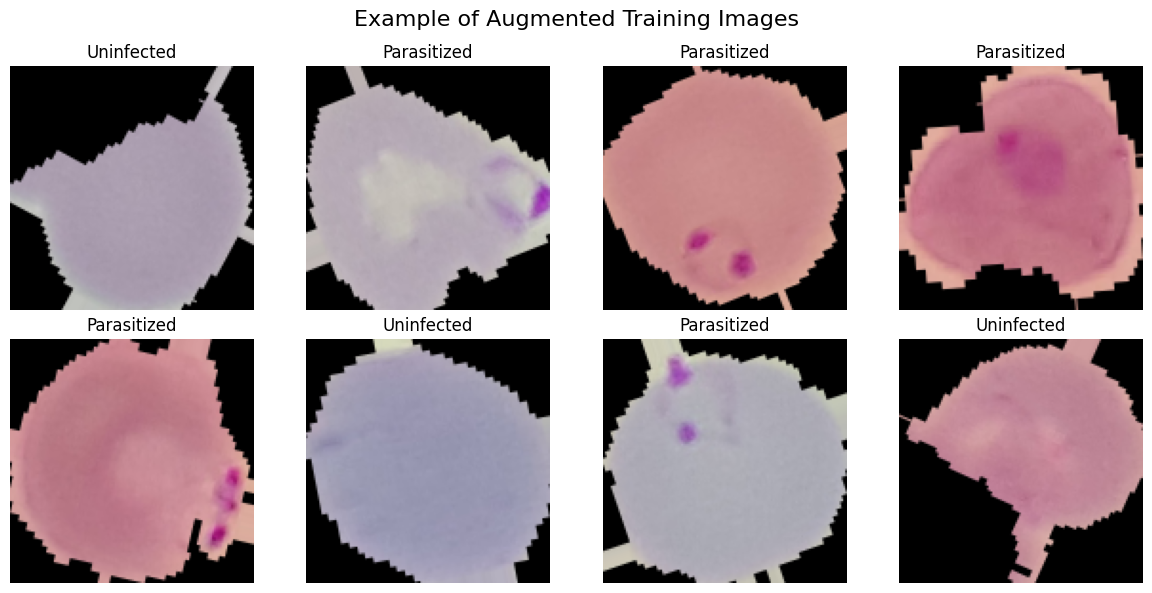

In [41]:
def plot_augmented_images(generator, n_images=8):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(n_images):
        ax = plt.subplot(2, n_images//2, i + 1)
        plt.imshow(x_batch[i])
        plt.title("Parasitized" if y_batch[i]==0 else "Uninfected")
        plt.axis("off")
    plt.suptitle("Example of Augmented Training Images", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_augmented_images(train_generator)


## Step 3: Build the Model using Transfer Learning

We use the pre-trained VGG16 model (without its top layers) to leverage existing feature extraction.  
A custom classifier is added on top.  
The model architecture is then visualized.
"""

In [43]:
import os
os.listdir()


['best_malaria_model.keras',
 'ZippedFolder.zip',
 'Malaria_CNN (1).ipynb',
 'malaria_dataset',
 'Untitled.ipynb',
 '.ipynb_checkpoints',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [44]:
inputs = Input(shape=(128, 128, 3))

base_model = VGG16(
    weights=None,
    include_top=False,
    input_tensor=inputs
)

base_model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

base_model.trainable = False

In [45]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

In [46]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Step 4: Set Up Callbacks and Train the Model

Callbacks such as EarlyStopping and ModelCheckpoint are used to monitor the training process and save the best model.  
We then train the model while capturing the training history.
"""

In [48]:
callbacks_list = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_malaria_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [62]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    verbose=1
)
history

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1588s 2s/step - accuracy: 0.9399 - loss: 0.1642 - val_accuracy: 0.9321 - val_loss: 0.1691
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.9409 - loss: 0.1632 - val_accuracy: 0.9220 - val_loss: 0.1920
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1211s 2s/step - accuracy: 0.9400 - loss: 0.1670 - val_accuracy: 0.9236 - val_loss: 0.1943
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1300s 2s/step - accuracy: 0.9410 - loss: 0.1591 - val_accuracy: 0.9292 - val_loss: 0.1762
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 2884s 4s/step - accuracy: 0.9434 - loss: 0.1532 - val_accuracy: 0.9205 - val_loss: 0.2012
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 21065s 31s/step - accuracy: 0.9445 - loss: 0.1538 - val_accuracy: 0.9303 - val_loss: 0.1720
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1513s 2s/step - accuracy: 0.9434 - loss: 0.1559 - val_accuracy: 0.9374 - val_loss: 0.1610
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.9435 - loss: 0.1489 

In [102]:

validation_datagen = ImageDataGenerator(rescale=1./255)

val_gen_eval = validation_datagen.flow_from_directory(
    data_root,          
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False       
)

Found 27558 images belonging to 2 classes.


In [94]:
val_gen_eval.reset()
y_true = val_gen_eval.classes

y_prob = model.predict(
    val_gen_eval,
    steps=len(val_gen_eval),
    verbose=1
).flatten()

y_pred = (y_prob >= 0.5).astype(int)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


862/862 ━━━━━━━━━━━━━━━━━━━━ 1468s 2s/step


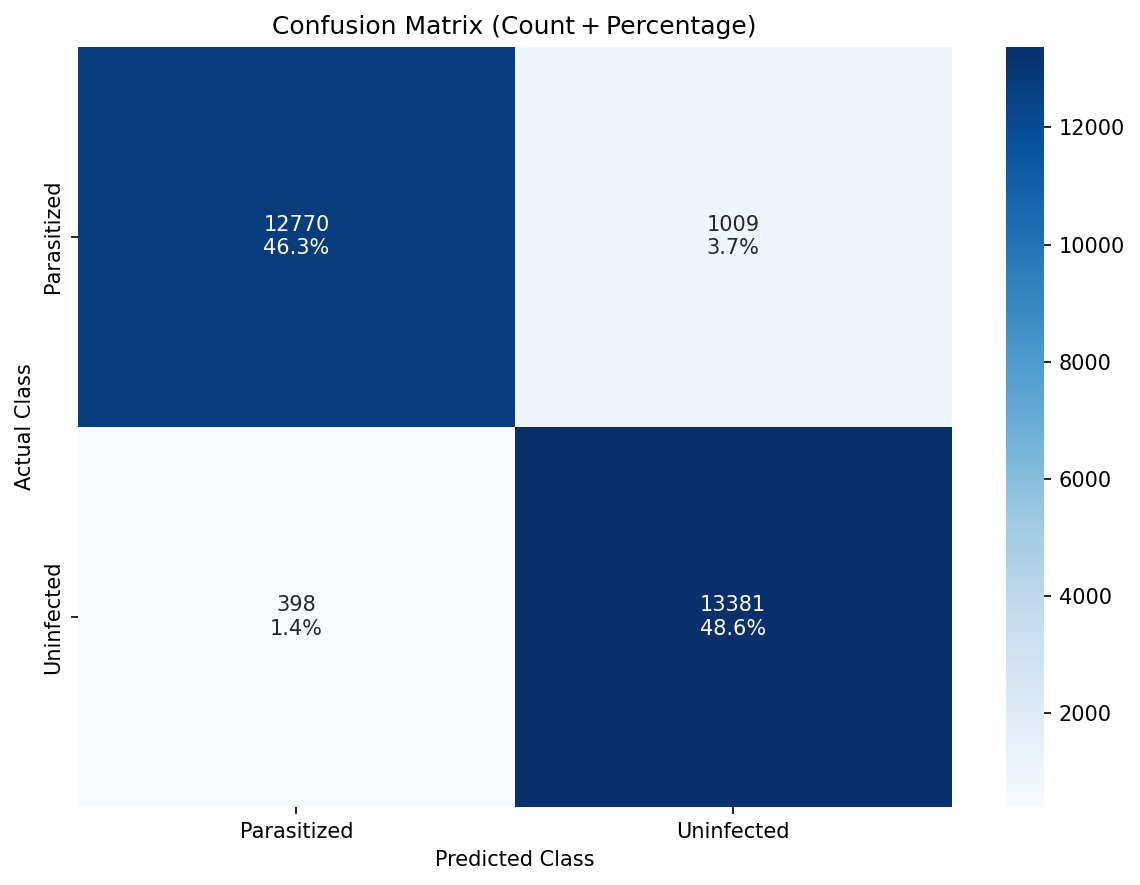

In [100]:
cm = confusion_matrix(y_true, y_pred)
labels = list(val_gen_eval.class_indices.keys())

# Create annotations with counts and percentages
total = cm.sum()
annot = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = count / total * 100
        annot[i, j] = f"{count}\n{pct:.1f}%"

plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix (Count + Percentage)')
plt.tight_layout()
plt.show()


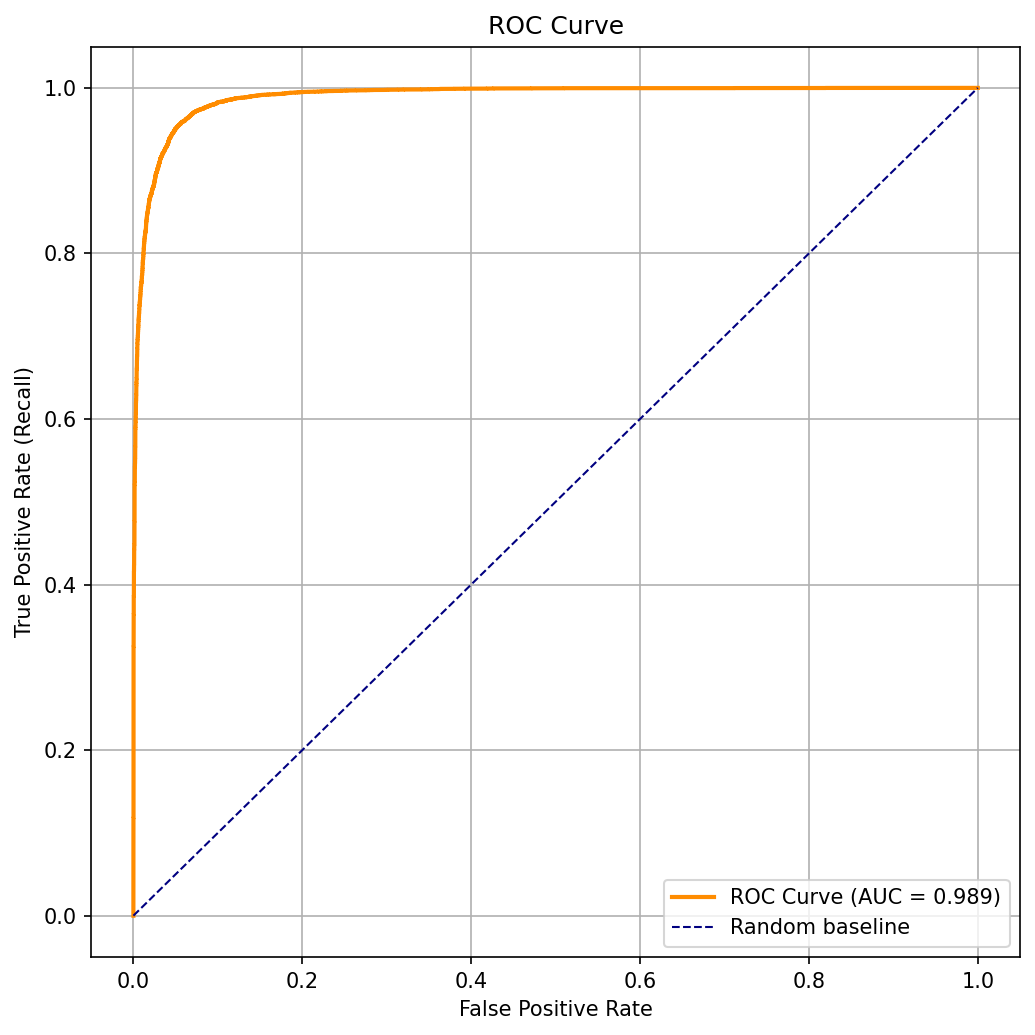

In [103]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7), dpi=150)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

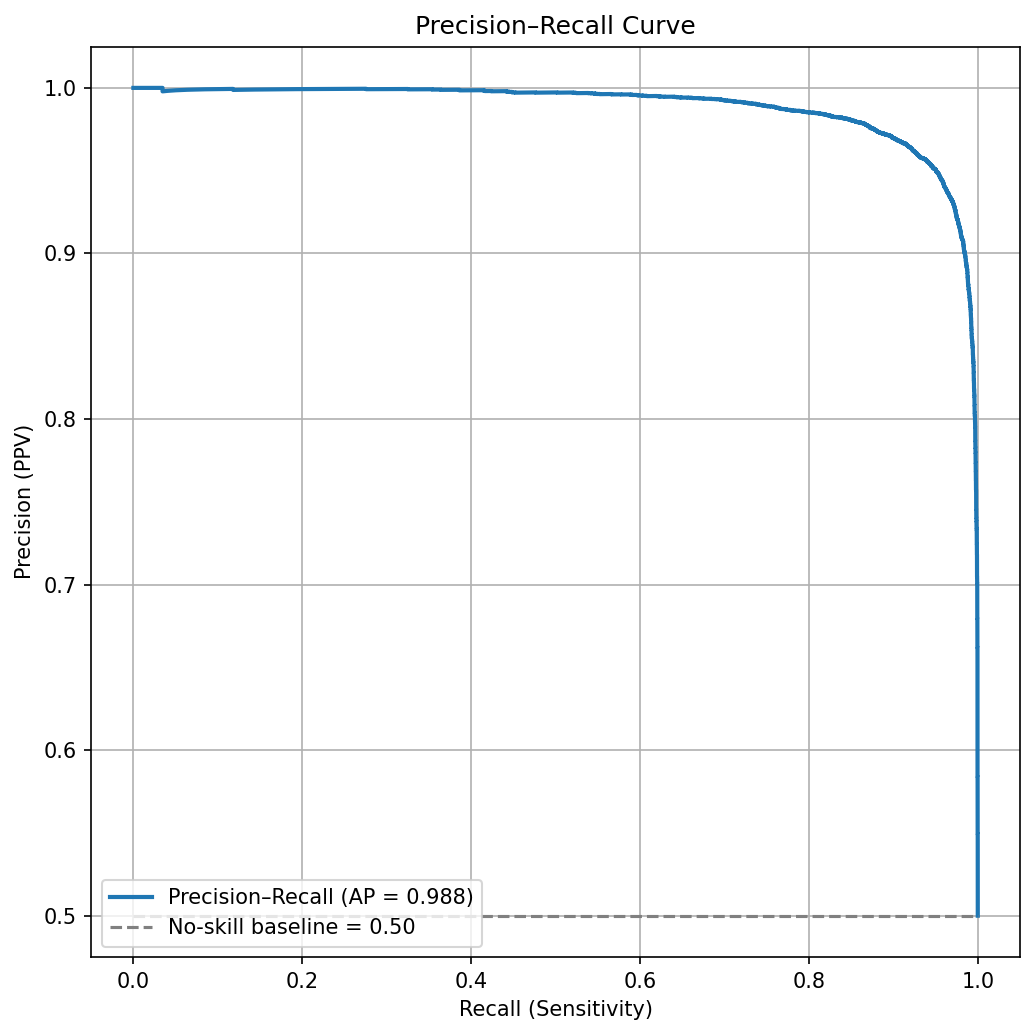

In [105]:
precision, recall, _ = precision_recall_curve(y_true, y_prob)
avg_prec = average_precision_score(y_true, y_prob)

plt.figure(figsize=(7, 7), dpi=150)
plt.plot(recall, precision, lw=2,
         label=f'Precision–Recall (AP = {avg_prec:.3f})')
baseline = y_true.mean()
plt.hlines(baseline, 0, 1, linestyle='--', color='gray',
           label=f'No‑skill baseline = {baseline:.2f}')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}\n")

print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy:  0.9489
Precision: 0.9299
Recall:    0.9711
F1 Score:  0.9501
Matthews Correlation Coefficient (MCC): 0.8988

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.97      0.93      0.95     13779
  Uninfected       0.93      0.97      0.95     13779

    accuracy                           0.95     27558
   macro avg       0.95      0.95      0.95     27558
weighted avg       0.95      0.95      0.95     27558

